# Multidimensional Angular Model (RGB visualization)


> For this notebook, the ``Pillow`` python package is required.

In [1]:
from qrobot.models import AngularModel

In this notebook we present a 3-dimensional ($n=3$) demo for the ``AngularModel`` class. For simplicity's sake, we consider $\tau = 1$

In [2]:
n = 3
tau = 1

## Plotting utils

Before starting, we define some plotting utils for the notebook:

In [3]:
from PIL import Image


def data2img(data):
    """Converts normalized input data to a 10x10 color image representation"""
    rgb = [round(d * 255) for d in data]
    return Image.new("RGB", (10, 10), tuple(rgb))

In [4]:
import matplotlib.pyplot as plt


class Plotter:
    def __init__(self):

        self.color_list = (
            (0, 0, 0),  # Black
            (255, 0, 0),  # Red
            (0, 255, 0),  # Green
            (255, 255, 0),  # Yellow
            (0, 0, 255),  # Blue
            (255, 0, 255),  # Violet
            (0, 255, 255),  # Cyan
            (255, 255, 255),  # White
        )

        self.states_dict = {
            1: "000",
            2: "001",
            3: "010",
            4: "011",
            5: "100",
            6: "101",
            7: "110",
            8: "111",
        }

    def plot_data(self, data):
        """Plots normalized data in 3d space with the correspondant color representation"""
        fig = plt.figure(figsize=(17, 3))

        # Plot the input color in the RGB space
        ax1 = fig.add_subplot(1, 5, 2, projection="3d")
        # Plot the 3d point
        ax1.scatter(data[0], data[1], data[2], marker="o")
        # Set the axis labels
        ax1.set_xlabel("Dim_1")
        ax1.set_ylabel("Dim_2")
        ax1.set_zlabel("Dim_3")
        # Set the fixed bounds of the axis
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        ax1.set_zlim([0, 1])

        # Plot the actual input color
        ax2 = plt.subplot(1, 5, 4)
        ax2.set_title("Data = {}\n".format(data))
        plt.imshow(data2img(data))

    def plot_result(self, data, counts, shots):
        """Plots the % obtained from the simulation for each basis states"""
        plt.figure(figsize=(15, 1), dpi=150)

        # Plot the input
        axis = plt.subplot(1, 10, 1)
        axis.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )
        axis.set_title("Input")
        axis.set_xlabel("{}".format(data))
        plt.imshow(data2img(data))

        # Plot all the probabilities
        for i in range(0, 8):
            axis = plt.subplot(1, 10, i + 2)
            axis.set_title("{}".format(self.states_dict[i + 1]))
            axis.tick_params(
                axis="both",
                which="both",
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                labeltop=False,
                labelleft=False,
                labelright=False,
            )
            try:
                axis.set_xlabel(f"{counts[self.states_dict[i+1]]/shots:%}")
            except KeyError:
                axis.set_xlabel(f"{0:%}")
            img = Image.new("RGB", (10, 10), self.color_list[i])
            plt.imshow(img)

In [5]:
plotter = Plotter()

## Input definition

We start by defining an arbirary input:

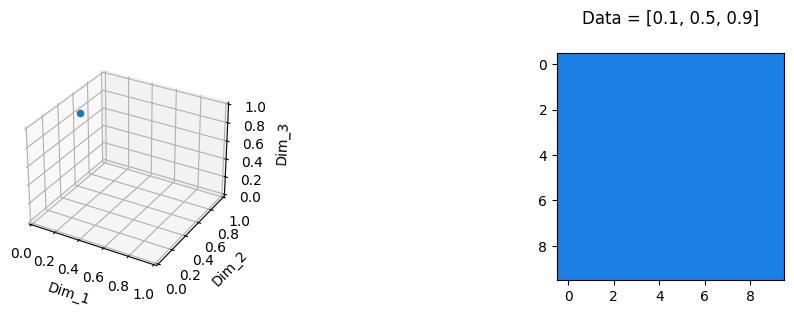

In [6]:
input_data = [0.1, 0.5, 0.9]
plotter.plot_data(input_data)

## Encode the input in the model

We initialize the model by instantiating an object with $n$ and $\tau$

In [7]:
model = AngularModel(n, tau)

Using the ``encode`` method, we  encode the event's tridimensional data in the model. Since we have a multidimensional inputs, two  loops are needed -in general- in order to loop through the $n$ dimensions of the input and then through time. Despite this, we considered $\tau = 1$, hence only one loop is needed:

In [8]:
model.clear()  # to re-initialize the model (allows re-runing this cell without double the encoding)

for dim in range(model.n):
    model.encode(input_data[dim], dim)

The model is implemented by a Qiskit quantum circuit:

In [9]:
model.print_circuit()

      ┌──────────┐
q_0: ─┤ Ry(π/10) ├
      ├─────────┬┘
q_1: ─┤ Ry(π/2) ├─
     ┌┴─────────┴┐
q_2: ┤ Ry(9π/10) ├
     └───────────┘
c: 3/═════════════
                  


Given the input we defined above, the model is in the following state:

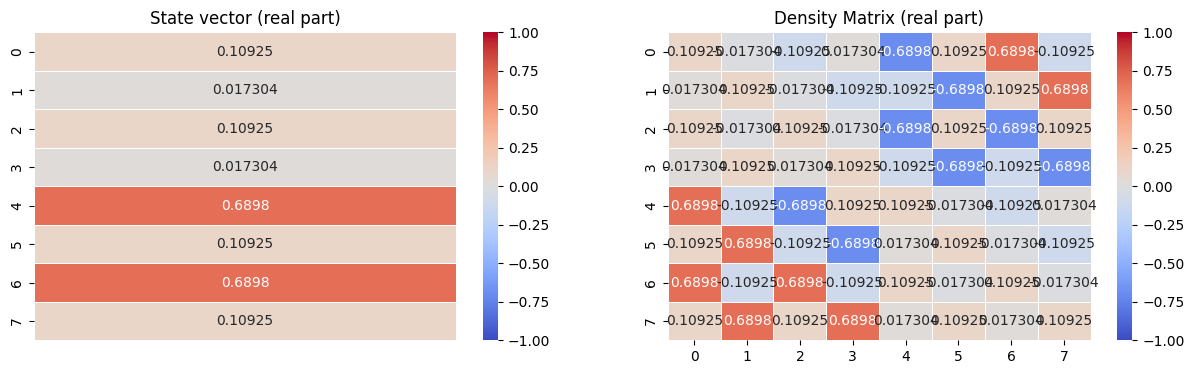

In [10]:
model.plot_state_mat()

## Measurement simulation

We simulate ``shots`` measurements, and then we extract the relative frequencies for the $2^n$ possible basis state outcomes:

In [11]:
shots = 1000000
counts = model.measure(shots)

Raw counts for each possible outcome:

In [12]:
import json

print("Aggregated binary outcomes of the circuit:")
print(json.dumps(counts, sort_keys=True, indent=4))

Aggregated binary outcomes of the circuit:
{
    "000": 11844,
    "001": 326,
    "010": 11802,
    "011": 299,
    "100": 475907,
    "101": 11986,
    "110": 475766,
    "111": 12070
}


From the raw counts we can obtain the relative frequencies (aka the probabilities) and compare them with the input sequence. Since we have not operated any change of basis (with the ``model.query(target)`` method), the canonical basis is maintained, and it is possible to visualize it still with our RGB representation:

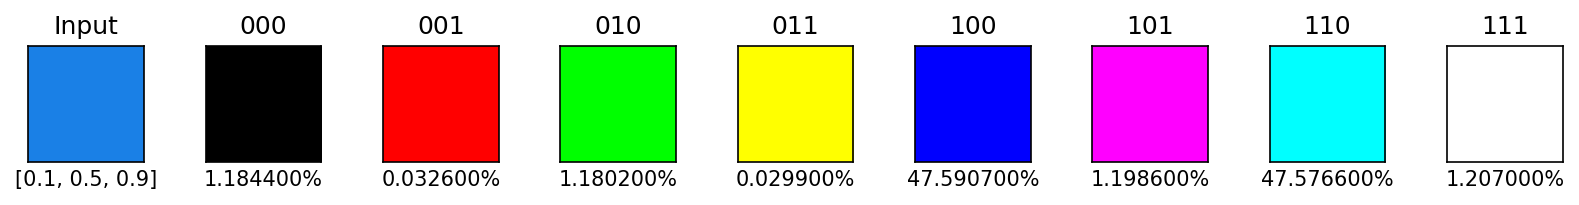

In [13]:
plotter.plot_result(input_data, counts, shots)